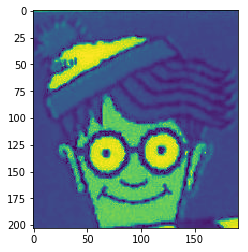

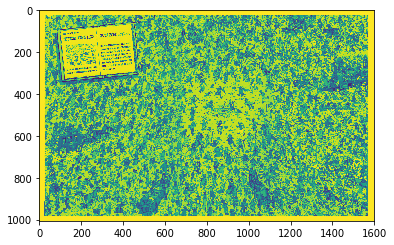

500
--
(455.0640869140625, 286.654541015625)
(335.9232482910156, 122.34241485595703)
(406.0, 157.0)
(315.187255859375, 114.04801940917969)
(141.0, 114.0)
(322.0, 171.0)
(216.0, 295.0)
(317.2608337402344, 124.416015625)
(148.0, 109.0)
(569.825439453125, 729.0779418945312)
(205.0, 290.0)
(953.8561401367188, 588.9024658203125)
(423.0, 204.0)
(320.0, 230.0)
(730.9691162109375, 361.9013671875)
(321.0, 236.0)
(128.16000366210938, 144.0)
(134.40000915527344, 286.8000183105469)
(123.60000610351562, 144.0)


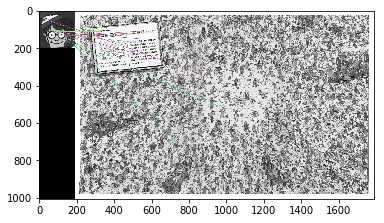

(<matplotlib.image.AxesImage at 0x7fd04023bba8>, None)

In [1]:
"""
Running ORB detector/descriptor
SURF can be run by using cv2.xfeatures2d.SURF_create(), but ORB does better, so i only included that.
"""

import numpy as np
import cv2
from matplotlib import pyplot as plt
import cyvlfeat as vlfeat

img1 = cv2.imread('templates/waldo/032/0.jpg',0)
plt.imshow(img1),plt.show()

img2 = cv2.imread('datasets/JPEGImages/003.jpg',0)
plt.imshow(img2),plt.show()

orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf.match(des1,des2)

matches.sort(key=lambda x: x.distance, reverse=False)

matches = matches[:int(len(matches)*0.1)]

print(len(kp2))
print("--")

for match in matches:
    print(kp2[match.trainIdx].pt)
    
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None, flags=2)
    
# you'll have to zoom in a lot to see the matched keypoints
plt.imshow(img3),plt.show()

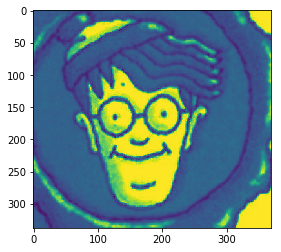

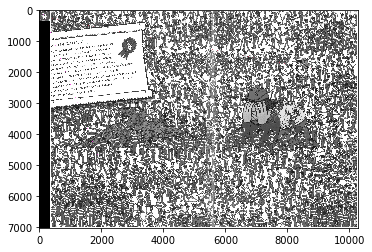

(<matplotlib.image.AxesImage at 0x7fd04018b9b0>, None)

In [2]:
"""
I was just testing out different approaches to detect, match and draw the matches.
This is a mixture of many different solutions on the internet and is very convoluted. 
It can be ignored for now.
"""

import numpy as np
import cv2
from matplotlib import pyplot as plt

def filter_matches(kp1, kp2, matches, ratio = 0.75):
    mkp1, mkp2 = [], []
    filtered = []
    for m in matches:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            m = m[0]
            mkp1.append( kp1[m.queryIdx] )
            mkp2.append( kp2[m.trainIdx] )
            filtered.append(m)
#     kp_pairs = zip(mkp1, mkp2)
    return (mkp1,mkp2,filtered)


def explore_match(win, img1, img2, kp_pairs, status = None, H = None):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    vis = numpy.zeros((max(h1, h2), w1+w2), numpy.uint8)
    vis[:h1, :w1] = img1
    vis[:h2, w1:w1+w2] = img2
    vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)

    if H is not None:
        corners = numpy.float32([[0, 0], [w1, 0], [w1, h1], [0, h1]])
        corners = numpy.int32( cv2.perspectiveTransform(corners.reshape(1, -1, 2), H).reshape(-1, 2) + (w1, 0) )
        cv2.polylines(vis, [corners], True, (255, 255, 255))

    if status is None:
        status = numpy.ones(len(kp_pairs), numpy.bool_)
    p1 = numpy.int32([kpp[0].pt for kpp in kp_pairs])
    p2 = numpy.int32([kpp[1].pt for kpp in kp_pairs]) + (w1, 0)

    green = (0, 255, 0)
    red = (0, 0, 255)
    white = (255, 255, 255)
    kp_color = (51, 103, 236)
    for (x1, y1), (x2, y2), inlier in zip(p1, p2, status):
        if inlier:
            col = green
            cv2.circle(vis, (x1, y1), 2, col, -1)
            cv2.circle(vis, (x2, y2), 2, col, -1)
        else:
            col = red
            r = 2
            thickness = 3
            cv2.line(vis, (x1-r, y1-r), (x1+r, y1+r), col, thickness)
            cv2.line(vis, (x1-r, y1+r), (x1+r, y1-r), col, thickness)
            cv2.line(vis, (x2-r, y2-r), (x2+r, y2+r), col, thickness)
            cv2.line(vis, (x2-r, y2+r), (x2+r, y2-r), col, thickness)
    vis0 = vis.copy()
    for (x1, y1), (x2, y2), inlier in zip(p1, p2, status):
        if inlier:
            cv2.line(vis, (x1, y1), (x2, y2), green)
    cv2.imshow(win, vis)   
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def draw_matches(window_name, kp_pairs, img1, img2):
    """Draws the matches for """
    mkp1, mkp2 = zip(*kp_pairs)

    p1 = numpy.float32([kp.pt for kp in mkp1])
    p2 = numpy.float32([kp.pt for kp in mkp2])

    if len(kp_pairs) >= 4:
        H, status = cv2.findHomography(p1, p2, cv2.RANSAC, 5.0)
    else:
        H, status = None, None
    if len(p1):
        explore_match(window_name, img1, img2, kp_pairs, status, H)

img1 = cv2.imread('templates/waldo/001/0.jpg',0)
plt.imshow(img1),plt.show()

img2 = cv2.imread('datasets/JPEGImages/001.jpg',0)
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

matcher = cv2.BFMatcher(cv2.NORM_L2)

matches = matcher.knnMatch(des1, des2, k=2) 

good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)
                
# M, mask = cv2.findHomography(np.asarray(kp1), np.asarray(kp2), cv2.RANSAC, 5.0)


img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,flags=2)

# if kp_pairs:
#     draw_matches('Matching Features', kp_pairs, img1, img2)    
# else:
#     print("No matches found")

# kp1_sorted = sorted(kp1, key = lambda x:x.pt[0])

# for kp in kp1_sorted:
#     print(kp.pt)

# # create BFMatcher object
# bf = cv2.BFMatcher()

# # Match descriptors.
# matches = bf.knnMatch(des1,des2, k=2)

# # Apply ratio test
# good = []
# for m,n in matches:
#     if m.distance < 0.7*n.distance:
#         good.append(m)

# src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
# dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

# M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
# matchesMask = mask.ravel().tolist()

# h,w = img1.shape
# pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
# dst = cv2.perspectiveTransform(pts,M)

# img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

# # Sort them in the order of their distance.
# matches = sorted(matches, key = lambda x:x.distance)

# for i,match in enumerate(matches):
#     if i==10:
#         break
#     print(f"{kp2[match.trainIdx].pt}, {match.distance}")

    
# draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                    singlePointColor = None,
#                    matchesMask = matchesMask, # draw only inliers
#                    flags = 2)

# img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()

In [125]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import cyvlfeat as vlfeat
from sklearn.svm import LinearSVC, SVC
import os.path as osp
from skimage import filters
from skimage.feature import corner_peaks
from skimage.io import imread
import pickle
from random import shuffle
from scipy.spatial.distance import cdist

In [143]:
def bags_of_sifts(image_paths=[], vocab_filename='', img=None):

    with open(vocab_filename, 'rb') as f:
        vocab = pickle.load(f)

    vocab_size = vocab.shape[0]
#     print(vocab_size)
    feats = []
    
    if len(image_paths) == 0:
        image_paths = ['']
    
    for path in image_paths:
        image = np.asarray(plt.imread(path)) if path != '' else img
        img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        (frames, descriptors) = vlfeat.sift.dsift(img_gray, fast=True, step=10)
        
        samples = descriptors
        
        D = cdist(samples, vocab)
        
        closest_words = np.argmin(D, axis=1)

#         for i in range(D.shape[0]):
#             min_index = np.argmin(D[i])
#             histogram[min_index]+=1

        histogram, bin_edges = np.histogram(closest_words, bins=np.arange(0, vocab_size+1))
#         print(histogram)

        if np.linalg.norm(histogram) == 0.0:
            print(descriptors.shape)
            print(D.shape)
            print(np.linalg.norm(histogram))
            print(img_gray.shape)
            print("--")
            
            
        histogram = histogram / np.linalg.norm(histogram)
        feats.append(histogram)
        
    N = len(image_paths)
    d = vocab_size
    feats = np.asarray(feats)
    feats = feats.reshape((N,d))
    return feats


def build_vocabulary(image_paths, vocab_size):
    dim = 128     
    vocab = np.zeros((vocab_size,dim))
    sift_features = []

    for path in image_paths:
        image = np.asarray(plt.imread(path))
        img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        (frames, descriptors) = vlfeat.sift.dsift(img_gray, fast=True, step=5)

        samples = np.random.permutation(descriptors)[:20]

        for descriptor in samples:
            sift_features.append(descriptor)

    sift_features = np.asarray(sift_features).astype('float64').reshape((-1,128))
    vocab = vlfeat.kmeans.kmeans(sift_features, vocab_size)

    return vocab


def svm_classify(train_image_feats, train_labels, test_image_feats):
    categories = list(set(train_labels))
    test_labels = []
    
    clf = SVC(C=20)
    clf.fit(train_image_feats, train_labels)
    test_labels = clf.predict(test_image_feats)

    return test_labels

def trainSVM(train_image_feats, train_labels):
    clf = SVC(C=20, gamma='auto', probability=True, decision_function_shape='ovo')
    clf.fit(train_image_feats, train_labels)
    
    return clf


def test_accuracy(test_labels, predicted_labels):
    num_correct = 0
    for i,label in enumerate(test_labels):
        if (predicted_labels[i] == label):
            num_correct += 1
    return num_correct/len(test_labels)

In [144]:
waldo_paths = []
wenda_paths = []
wizard_paths = []
all_paths = []

test_image_paths = []
with open('datasets/ImageSets/val.txt') as file:
    for img_id in file.readlines():
        img_id = img_id.rstrip()
        test_image_paths.append('datasets/JPEGImages/{}.jpg'.format(img_id))

file.close()


template_dirs = ["templates/waldo","templates/wenda","templates/wizard"]

for i in range(len(template_dirs)):
    for img_id in os.listdir(template_dirs[i]):
        path_to_dir = os.path.join(template_dirs[i], '{}'.format(img_id)).rstrip()
        if not os.path.isdir(path_to_dir):
            continue
        list_of_files = os.listdir(path_to_dir)
        for file_name in list_of_files:
            all_paths.append(os.path.join(path_to_dir, '{}'.format(file_name)).rstrip())
            if i==0:
                waldo_paths.append(os.path.join(path_to_dir, '{}'.format(file_name)).rstrip())
            if i==1:
                wenda_paths.append(os.path.join(path_to_dir, '{}'.format(file_name)).rstrip())
            if i==2:
                wizard_paths.append(os.path.join(path_to_dir, '{}'.format(file_name)).rstrip())

negative_samples_dir = "negatives_same_scale"
negative_samples_paths = []
for file_name in os.listdir(negative_samples_dir):
    if file_name == '.DS_Store':
        continue
    all_paths.append(os.path.join(negative_samples_dir, '{}'.format(file_name)).rstrip())
    negative_samples_paths.append(os.path.join(negative_samples_dir, '{}'.format(file_name)).rstrip())
                
# print(sorted(all_paths))
print(len(negative_samples_paths))
print(len(waldo_paths))
print(len(wenda_paths))
print(len(wizard_paths))

484
137
43
27


In [145]:
# get vocab
print('Using the BAG-OF-SIFT representation for images')

vocab_filename = 'vocab.pkl'

# print('No existing visual word vocabulary found. Computing one from training images')
vocab_size = 200  # Larger values will work better (to a point) but be slower to compute
vocab = build_vocabulary(all_paths,vocab_size)
print(np.isnan(vocab).any())
    
with open(vocab_filename, 'wb') as f:
    pickle.dump(vocab, f)

    print('{:s} saved'.format(vocab_filename))

Using the BAG-OF-SIFT representation for images
False
vocab.pkl saved


In [146]:
#get bags of sifts
template_percentage = 0.9

print(f"all_feats = {len(all_paths)}")

# waldo_feats = bags_of_sifts(waldo_paths,vocab_filename)
# wenda_feats = bags_of_sifts(wenda_paths,vocab_filename)
# wizard_feats = bags_of_sifts(wizard_paths,vocab_filename)

# print(np.isnan(waldo_feats).any())
# print(np.isnan(wenda_feats).any())
# print(np.isnan(wizard_feats).any())

# print(waldo_feats)
# print(wenda_feats)
# print(wizard_feats)


waldo_feats = bags_of_sifts(waldo_paths[:int(len(waldo_paths)*template_percentage)],vocab_filename)
wenda_feats = bags_of_sifts(wenda_paths[:int(len(wenda_paths)*template_percentage)],vocab_filename)
wizard_feats = bags_of_sifts(wizard_paths[:int(len(wizard_paths)*template_percentage)],vocab_filename)
negatives_feats = bags_of_sifts(negative_samples_paths[:int(len(negative_samples_paths)*template_percentage)], vocab_filename)

training_feats = []
training_feats.extend(waldo_feats)
training_feats.extend(wenda_feats)
training_feats.extend(wizard_feats)
training_feats.extend(negatives_feats)

print(len(waldo_feats))
print(len(wenda_feats))
print(len(wizard_feats))
print(len(negatives_feats))
print("--\ntest_feats_lengths")

# test_image_feats 
waldo_test_feats = bags_of_sifts(waldo_paths[int(len(waldo_paths)*template_percentage):len(waldo_paths)],vocab_filename)
wenda_test_feats = bags_of_sifts(wenda_paths[int(len(wenda_paths)*template_percentage):len(wenda_paths)],vocab_filename)
wizard_test_feats = bags_of_sifts(wizard_paths[int(len(wizard_paths)*template_percentage):len(wizard_paths)],vocab_filename)
negatives_test_feats = bags_of_sifts(negative_samples_paths[int(len(negative_samples_paths)*template_percentage):len(negative_samples_paths)],vocab_filename)

test_feats = []
test_feats.extend(waldo_test_feats)
test_feats.extend(wenda_test_feats)
test_feats.extend(wizard_test_feats)
test_feats.extend(negatives_test_feats)

#set training labels
train_labels = []
train_labels.extend(["waldo"]*len(waldo_feats))
train_labels.extend(["wenda"]*len(wenda_feats))
train_labels.extend(["wizard"]*len(wizard_feats))
train_labels.extend(["none"]*len(negatives_feats))

print(len(waldo_test_feats))
print(len(wenda_test_feats))
print(len(wizard_test_feats))
print("--\ntest_labels lengths")

ground_truth_test_labels = []
ground_truth_test_labels.extend(["waldo"]*len(waldo_test_feats))
ground_truth_test_labels.extend(["wenda"]*len(wenda_test_feats))
ground_truth_test_labels.extend(["wizard"]*len(wizard_test_feats))
ground_truth_test_labels.extend(["none"]*len(negatives_test_feats))

print(len(ground_truth_test_labels))

print(len(train_labels))
print(len(training_feats))
print("--")

print("done")

all_feats = 691
123
38
24
435
--
test_feats_lengths
14
5
3
--
test_labels lengths
71
620
620
--
done


In [108]:
template_percentage = 0.9

waldo_feats = bags_of_sifts(waldo_paths[:int(len(waldo_paths)*template_percentage)],vocab_filename)
wenda_feats = bags_of_sifts(wenda_paths[:int(len(wenda_paths)*template_percentage)],vocab_filename)
wizard_feats = bags_of_sifts(wizard_paths[:int(len(wizard_paths)*template_percentage)],vocab_filename)
negatives_feats = bags_of_sifts(negative_samples_paths[:int(len(negative_samples_paths)*template_percentage)], vocab_filename)


### Train waldo features into one classifier
non_waldo_feats = []
non_waldo_feats.extend(wenda_feats)
non_waldo_feats.extend(wizard_feats)
non_waldo_feats.extend(negatives_feats)

waldo_training_feats = []
waldo_training_feats.extend(waldo_feats)
waldo_training_feats.extend(non_waldo_feats)

waldo_labels = []
waldo_labels.extend(["waldo"]*len(waldo_feats))
waldo_labels.extend(["not-waldo"]*len(non_waldo_feats))

waldo_classifier = trainSVM(waldo_training_feats, waldo_labels)

### end waldo training

### Train wenda features into one classifier
non_wenda_feats = []
non_wenda_feats.extend(waldo_feats)
non_wenda_feats.extend(wizard_feats)
non_wenda_feats.extend(negatives_feats)

wenda_training_feats = []
wenda_training_feats.extend(wenda_feats)
wenda_training_feats.extend(non_wenda_feats)

wenda_labels = []
wenda_labels.extend(["wenda"]*len(wenda_feats))
wenda_labels.extend(["not-wenda"]*len(non_wenda_feats))

wenda_classifier = trainSVM(wenda_training_feats, wenda_labels)
### end wenda training

### Train wizard features into one classifier
non_wizard_feats = []
non_wizard_feats.extend(waldo_feats)
non_wizard_feats.extend(wenda_feats)
non_wizard_feats.extend(negatives_feats)

wizard_training_feats = []
wizard_training_feats.extend(wizard_feats)
wizard_training_feats.extend(non_wizard_feats)

wizard_labels = []
wizard_labels.extend(["wizard"]*len(wizard_feats))
wizard_labels.extend(["not-wizard"]*len(non_wizard_feats))

wizard_classifier = trainSVM(wizard_training_feats, wizard_labels)
### end wizard training


waldo_test_feats = bags_of_sifts(waldo_paths[int(len(waldo_paths)*template_percentage):len(waldo_paths)],vocab_filename)
wenda_test_feats = bags_of_sifts(wenda_paths[int(len(wenda_paths)*template_percentage):len(wenda_paths)],vocab_filename)
wizard_test_feats = bags_of_sifts(wizard_paths[int(len(wizard_paths)*template_percentage):len(wizard_paths)],vocab_filename)
negatives_test_feats = bags_of_sifts(negative_samples_paths[int(len(negative_samples_paths)*template_percentage):len(negative_samples_paths)],vocab_filename)

not_waldo_test_feats = []
not_waldo_test_feats.extend(wenda_test_feats)
not_waldo_test_feats.extend(wizard_test_feats)
not_waldo_test_feats.extend(negatives_test_feats)

waldo_test = []
waldo_test.extend(waldo_test_feats)
waldo_test.extend(not_waldo_test_feats)

not_wenda_test_feats = []
not_wenda_test_feats.extend(waldo_test_feats)
not_wenda_test_feats.extend(wizard_test_feats)
not_wenda_test_feats.extend(negatives_test_feats)

wenda_test = []
wenda_test.extend(wenda_test_feats)
wenda_test.extend(not_wenda_test_feats)

not_wizard_test_feats = []
not_wizard_test_feats.extend(waldo_test_feats)
not_wizard_test_feats.extend(wenda_test_feats)
not_wizard_test_feats.extend(negatives_test_feats)

wizard_test = []
wizard_test.extend(wizard_test_feats)
wizard_test.extend(not_wizard_test_feats)

ground_truth_test_labels_waldo = []
ground_truth_test_labels_waldo.extend(["waldo"]*len(waldo_test_feats))
ground_truth_test_labels_waldo.extend(["not-waldo"]*len(not_waldo_test_feats))


ground_truth_test_labels_wenda = []
ground_truth_test_labels_wenda.extend(["wenda"]*len(wenda_test_feats))
ground_truth_test_labels_wenda.extend(["not-wenda"]*len(not_wenda_test_feats))


ground_truth_test_labels_wizard = []
ground_truth_test_labels_wizard.extend(["wizard"]*len(wizard_test_feats))
ground_truth_test_labels_wizard.extend(["not-wizard"]*len(not_wizard_test_feats))

test_labels_waldo = waldo_classifier.predict(waldo_test)
test_labels_wenda = wenda_classifier.predict(wenda_test)
test_labels_wizard = wizard_classifier.predict(wizard_test)

print(test_accuracy(ground_truth_test_labels_waldo, test_labels_waldo))
print(test_accuracy(ground_truth_test_labels_wenda, test_labels_wenda))
print(test_accuracy(ground_truth_test_labels_wizard, test_labels_wizard))


0.8309859154929577
0.9295774647887324
0.9436619718309859


In [147]:
# predicted_labels = svm_classify(training_feats, train_labels, test_feats)
trained_svm = trainSVM(training_feats, train_labels)

In [130]:
print(test_accuracy(ground_truth_test_labels, predicted_labels))

print(predicted_labels)

0.7746478873239436
['waldo' 'waldo' 'waldo' 'none' 'waldo' 'none' 'waldo' 'waldo' 'none'
 'none' 'waldo' 'waldo' 'none' 'waldo' 'none' 'none' 'wenda' 'none' 'waldo'
 'none' 'waldo' 'none' 'none' 'none' 'none' 'none' 'none' 'none' 'none'
 'none' 'none' 'none' 'none' 'none' 'none' 'none' 'none' 'none' 'none'
 'waldo' 'none' 'none' 'none' 'none' 'none' 'none' 'none' 'none' 'waldo'
 'none' 'none' 'none' 'none' 'none' 'none' 'none' 'none' 'none' 'none'
 'none' 'waldo' 'none' 'none' 'none' 'none' 'none' 'none' 'waldo' 'none'
 'none' 'none']


In [161]:
def svm_probability(train_image_feats, train_labels, test_image_feats):
    categories = list(set(train_labels))
    test_labels = []
    
    clf = SVC(C=2, gamma='scale', probability=True, decision_function_shape='ovo')
    clf.fit(train_image_feats, train_labels)
    test_probabilities = clf.predict_proba(test_image_feats)

    return test_probabilities

def sliding_window(window_size=20, step_size=1):
    f = open('datasets/ImageSets/val.txt')
    wa = open('baseline/waldo.txt', 'w+')
    we = open('baseline/wenda.txt', 'w+')
    wi = open('baseline/wizard.txt', 'w+')
    
    count=1
    image_id = f.readline().rstrip()
    while image_id:
        image = np.asarray(plt.imread('datasets/JPEGImages/' + image_id + '.jpg'))
        height, width, c = image.shape
        
        test_feats = []
        
#         print((height-window_size) * (width-window_size))
#         print(f"{height},{width}")
        
        #get the keypoints of the image
        #loop through these keypoints only => saves computation time
        orb = cv2.ORB_create(nfeatures=2500)
        img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        kp, des = orb.detectAndCompute(img_gray, None)
        
        ct=0
        for idx in range(len(kp)):
            j,i = kp[idx].pt

            i = int(np.round(i))
            j = int(np.round(j))
#             print(f"{ct}. {i} {j}")
            
            i_limit = i+window_size
            j_limit = j+window_size
            if i_limit >= height:
                i_limit = height-1
            if j_limit >= width:
                j_limit = width-1
            img = image[i:i_limit,j:j_limit]
#             print(f"{i}:{i_limit} {j}:{j_limit}")
            feats = bags_of_sifts(vocab_filename=vocab_filename, img=img)
            test_feats.extend(feats)
            ct += 1

#         print(test_feats)
#         print("--")
        
        #hilda's code: sliding window along entire image
#         test_feats=[]
#         for i in range(0, height-window_size, step_size):
#             for j in range(0, width-window_size, step_size):
#                 img = image[i:i+window_size, j:j+window_size]
#                 feats = bags_of_sifts(vocab_filename=vocab_filename, img=img)
#                 test_feats.extend(feats)
#                 if j==1: 
#                     break
#             break

#         print(len(test_feats))
#         predicted_probabilities = svm_probability(training_feats, train_labels, test_feats)
        predicted_probabilities = trained_svm.predict_proba(test_feats)
#         print(predicted_probabilities)
#         locations = np.argmax(predicted_probabilities, axis=0)
        locations = np.argsort(-predicted_probabilities,axis=0)[:25]
#         print(locations)
        # hilda's code
        conf = np.max(predicted_probabilities, axis=0)
#         print(conf)
        
        for num_iter in range(len(locations)):
            for k in range(len(locations[num_iter])):
                
                #hilda's code
#                 i = locations[k] // (height-window_size)
#                 j = locations[k] % (width-window_size)
                j_new, i_new  = kp[locations[num_iter][k]].pt  # location of best-fit window of character k

                i_new = int(np.round(i_new))
                j_new = int(np.round(j_new))
    #             print(f"{locations[k]}. {i_new} {j_new}")
                i_limit_new = i_new+window_size
                j_limit_new = j_new+window_size

                if i_limit_new >= height:
                    i_limit_new = height-1
                if j_limit_new >= width:
                    j_limit_new = width-1

                patch = image[i_new:i_limit_new, j_new:j_limit_new]
    #             plt.imshow(patch, interpolation='nearest')
    #             plt.show()

    #             res = image_id + ' ' + str(np.max(predicted_probabilities[locations[k]])) + ' ' + str(i) + ' ' + str(i+window_size) + ' ' + str(j) + ' ' + str(j+window_size) + '\n'
    #             print(res)
                if k == 0:
                    res = image_id + ' ' + str(predicted_probabilities[locations[num_iter][k]][k]) + ' ' + str(i_new) + ' '  +  str(j_new) + ' ' + str(i_limit_new) + ' ' + str(j_limit_new) + '\n'
    #                 print(res)
                    wa.write(res)
                if k == 1:
                    res = image_id + ' ' + str(np.max(predicted_probabilities[locations[num_iter][k]][k])) + ' ' + str(i_new) + ' ' + str(j_new) + ' ' + str(i_limit_new) + ' ' + str(j_limit_new) + '\n'
    #                 print(res)
                    we.write(res)
                if k == 2:
                    res = image_id + ' ' + str(np.max(predicted_probabilities[locations[num_iter][k]][k])) + ' ' + str(i_new) + ' '  + str(j_new) + ' ' + str(i_limit_new) + ' ' + str(j_limit_new) + '\n'
    #                 print(res)
                    wi.write(res)
                if k==3:
                    continue
#             break

        print(f"img {count}: {image_id}.jpg done")
        count+=1
        image_id = f.readline().rstrip()


sliding_window(50)

img 1: 003.jpg done
img 2: 018.jpg done
img 3: 036.jpg done
img 4: 043.jpg done
img 5: 038.jpg done
img 6: 056.jpg done
img 7: 067.jpg done
img 8: 074.jpg done


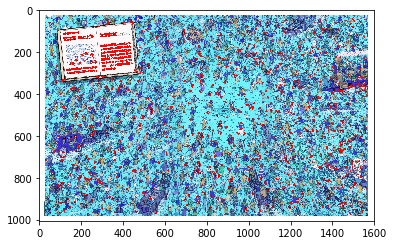

(<matplotlib.image.AxesImage at 0x1c28709198>, None)

In [120]:
img = cv2.imread('datasets/JPEGImages/003.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
orb = cv2.ORB_create(nfeatures=5000)
corners, des = orb.detectAndCompute(gray, None)
# corners = np.int0(corners)
for (i,corner) in enumerate(corners):
    x,y = corners[i].pt
    x = int(x)
    y = int(y)
    cv2.circle(img,(x,y),3,255,-1)
plt.imshow(img),plt.show()